# Anomaly Detection using PyOD Framework

- Imports

In [96]:

try:
    import os
    import numpy as np
    import pandas as pd
    import seaborn as sns
    import matplotlib.pyplot as plt
    from sklearn.experimental import enable_iterative_imputer
    from sklearn.impute import IterativeImputer
    from sklearn.impute import SimpleImputer
    from sklearn.feature_selection import SelectPercentile, chi2
    from sklearn.calibration import LabelEncoder
    from sklearn.preprocessing import MinMaxScaler
    from sklearn.model_selection import train_test_split
    from sklearn.model_selection import RandomizedSearchCV
    from sklearn.metrics import pairwise_distances, roc_auc_score, silhouette_score
    from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
    from sklearn.cluster import KMeans
    from pyod.models.knn import KNN
    from pyod.models.ocsvm import OCSVM
    from pyod.models.loda import LODA
    from scipy.stats import chi2_contingency
except ImportError:
    print("Installing required packages")
    import sys
    !{sys.executable} -m pip install pandas numpy matplotlib pyod sklearn

- Constants

In [47]:
TRAIN_DATA_DIRECTORY = './archive/data/train'
TEST_DATA_DIRECTORY = './archive/data/test'

TRAIN_DATASET_PATH = './datasets/falling_people_train.csv'
TEST_DATASET_PATH = './datasets/falling_people_test.csv'

TARGET = 'anomaly'

- Datasets Loading

In [48]:
def load_dataset(directory, kind, destination):
    df = pd.DataFrame({})
    for csv in os.listdir(directory):
        data = pd.read_csv(f'{directory}/{csv}')
        df = pd.concat([df, data])

    df.to_csv(destination, index=False)

In [49]:
if not os.path.exists('datasets'):
    os.makedirs('datasets')

- Train Dataset

In [50]:
load_dataset(TRAIN_DATA_DIRECTORY, 'train', TRAIN_DATASET_PATH)

- Test Dataset

In [51]:
load_dataset(TEST_DATA_DIRECTORY, 'test', TEST_DATASET_PATH)

- Dataset Reading

In [52]:
def read_dataset(source, target):
    X = pd.read_csv(source)
    y = X[target]
    X = X.drop(columns=[target])
    X = X.iloc[:, :]
    return X, y

- Data Splitting

In [53]:
fp_train, anomaly_train = read_dataset(TRAIN_DATASET_PATH, TARGET)
fp_test, anomaly_test = read_dataset(TEST_DATASET_PATH, TARGET)

# EDA

In [54]:
fp_train.nunique()

x                  134227
y                  134229
z                  134228
010-000-024-033         2
010-000-030-096         2
020-000-032-221         2
020-000-033-111         2
dtype: int64

In [55]:
fp_test.nunique()

x                  30030
y                  30030
z                  30030
010-000-024-033        2
010-000-030-096        2
020-000-032-221        2
020-000-033-111        2
dtype: int64

In [56]:
numerical_columns = [
    'x',
    'y',
    'z'
]

categorical_columns = [
    '010-000-024-033',
    '010-000-030-096',
    '020-000-032-221',
    '020-000-033-111'
]

In [57]:
fp_train[numerical_columns].describe()

,x,y,z
count,134229.000000,134229.000000,134229.000000
mean,13.189512,12.184366,11.383458
std,3.868037,2.705422,2.018636
min,4.077736,6.042775,4.600291
25%,9.676778,10.162940,9.975850
50%,13.701333,11.625925,11.344621
75%,16.345594,14.277065,12.933669
max,24.360715,19.633268,16.296521


In [58]:
fp_test[numerical_columns].describe()

,x,y,z
count,30030.000000,30030.000000,30030.000000
mean,12.783800,13.518438,11.650373
std,3.783162,2.796557,2.304254
min,4.661255,8.415395,5.502640
25%,9.548767,11.297357,9.896842
50%,13.164281,12.519715,11.066239
75%,16.597148,15.717042,13.677910
max,19.773056,19.895179,16.902571


In [59]:
fp_train[numerical_columns + categorical_columns].count()

x                  134229
y                  134229
z                  134229
010-000-024-033    134229
010-000-030-096    134229
020-000-032-221    134229
020-000-033-111    134229
dtype: int64

In [60]:
fp_test[numerical_columns + categorical_columns].count()

x                  30030
y                  30030
z                  30030
010-000-024-033    30030
010-000-030-096    30030
020-000-032-221    30030
020-000-033-111    30030
dtype: int64

In [61]:
anomaly_train.count()

134229

In [62]:
anomaly_test.count()

30030

- Deci putem observa ca nu avem valori lipsa in setul de date. Acest lucru desemneaza faptul ca nu vom avea nevoie de imputare de date lipsa cel putin pana la eliminarea outlier-elor.

In [63]:
class EDA:
    def __init__(self, dataset, target, numerical_columns, categorical_columns):
        self.dataset = dataset
        self.target = target
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns

    def boxplots(self):
        num_columns = len(self.numerical_columns)
        ncols = 3
        nrows = (num_columns + ncols - 1) // ncols

        fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
        axes = axes.flatten()

        for i, column in enumerate(self.numerical_columns):
            axes[i].boxplot(self.dataset[column].dropna(), labels=[column])
            axes[i].set_title(column)
            axes[i].set_ylabel('Values')

        for j in range(i + 1, len(axes)):
            axes[j].axis('off')

        plt.tight_layout()
        plt.show()

    def histograms(self):
        num_columns = len(self.categorical_columns)
        ncols = 3
        nrows = (num_columns + ncols - 1) // ncols

        fig, axes = plt.subplots(nrows, ncols, figsize=(15, 5 * nrows))
        axes = axes.flatten()

        for i, column in enumerate(self.categorical_columns):
            self.dataset[column].hist(bins=self.dataset[column].value_counts().shape[0], ax=axes[i])
            axes[i].set_xlabel(column)
            axes[i].set_ylabel('Frequency')
            axes[i].set_title(column)

    def targets_balance(self):
        sns.countplot(x=self.target, data=self.target.dropna().to_frame())
        plt.title('Target balance')
        plt.show()

    def plot_corr_matrix_numerical(self):
        corr_matrix = self.dataset[self.numerical_columns].corr(method='pearson')
        plt.figure(figsize=(8, 6))
        sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')
        plt.title('Correlation matrix')
        plt.show()

    def plot_corr_matrix_categorical(self):
        matrix = pd.DataFrame(index=self.categorical_columns, columns=self.categorical_columns)

        for i in range(len(self.categorical_columns)):
            for j in range(i, len(self.categorical_columns)):
                if i == j:
                    matrix.at[self.categorical_columns[i], self.categorical_columns[j]] = 1
                    continue

                attribute1 = self.categorical_columns[i]
                attribute2 = self.categorical_columns[j]
                
                table = pd.crosstab(self.dataset[attribute1], self.dataset[attribute2], margins=False)
                _, p, _, _ = chi2_contingency(table)
                matrix.at[attribute1, attribute2] = 1 - p
                matrix.at[attribute2, attribute1] = 1 - p

        plt.figure(figsize=(8, 6))
        sns.heatmap(matrix.astype(float), annot=True, cmap='coolwarm')
        plt.title('Correlation matrix')
        plt.show()

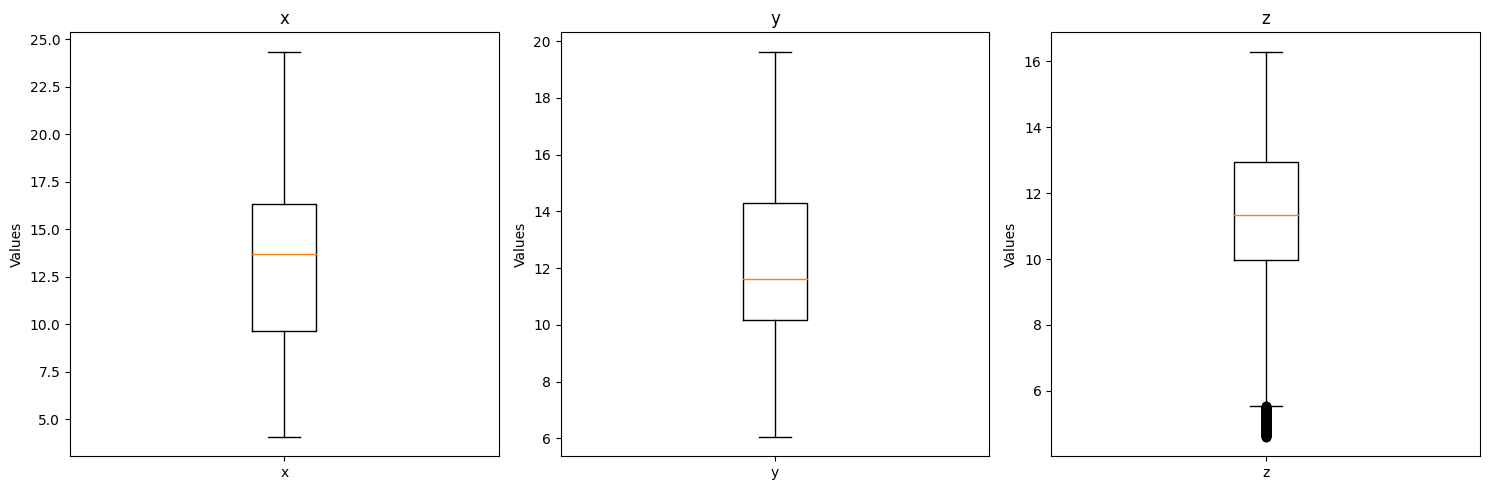

In [64]:
eda = EDA(dataset=fp_train, target=anomaly_train, numerical_columns=numerical_columns, categorical_columns=categorical_columns)
eda.boxplots()

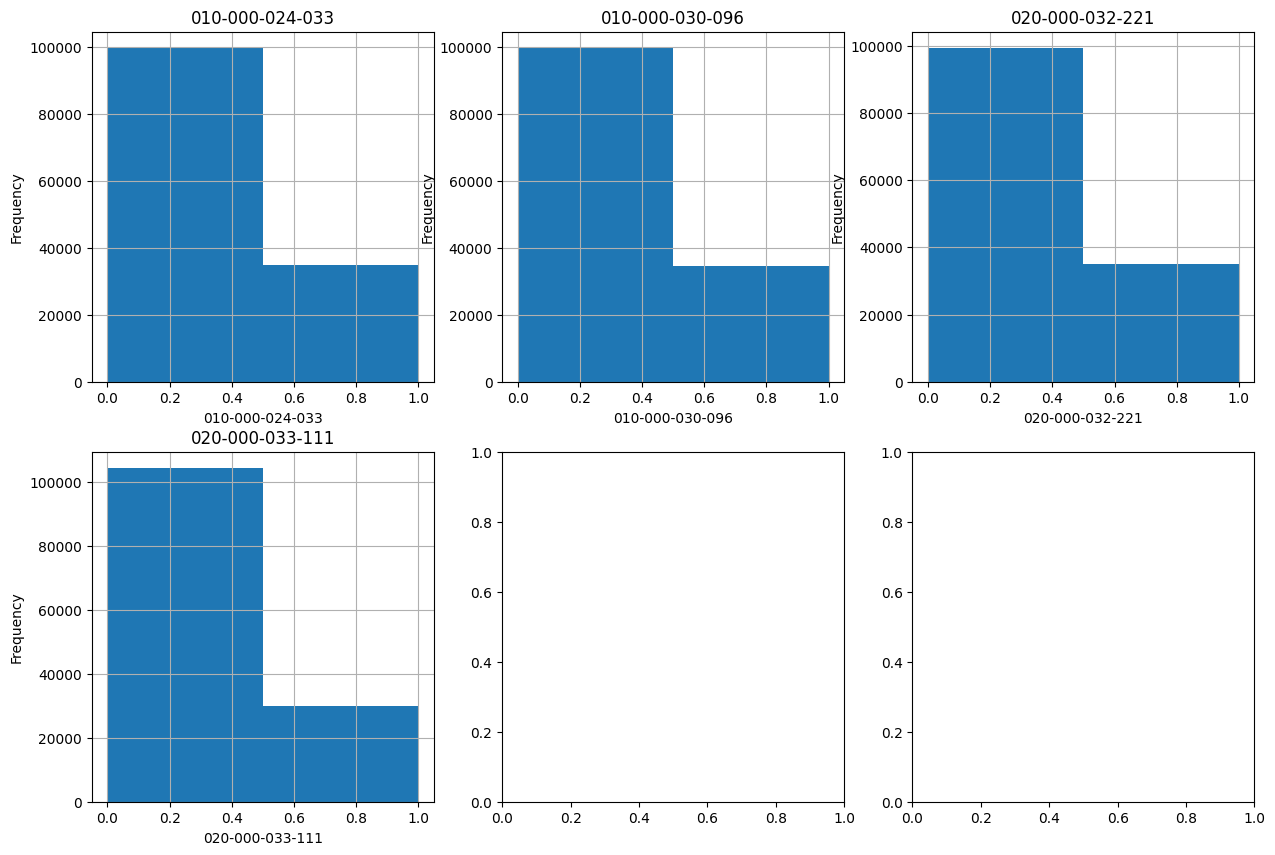

In [65]:
eda.histograms()

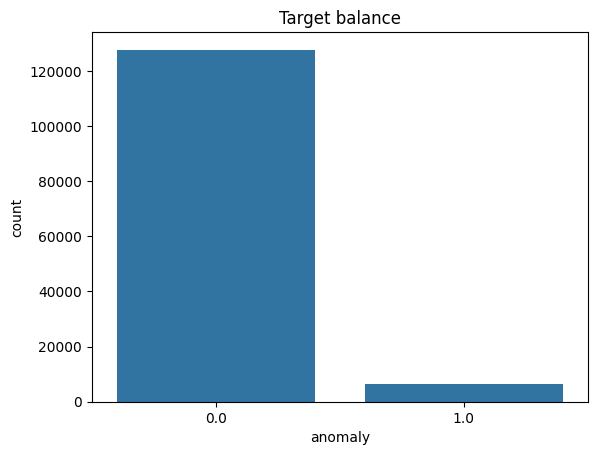

In [66]:
eda.targets_balance()

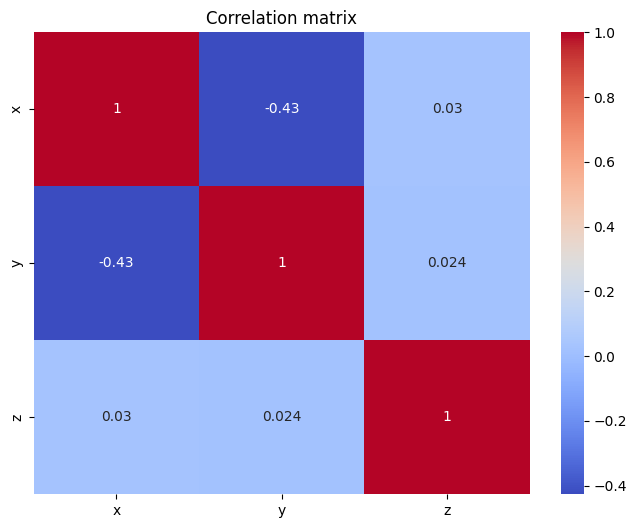

In [67]:
eda.plot_corr_matrix_numerical()

- Matricea de corelatie ne arata ca atributele numerice nu sunt chiar atat de corelate.

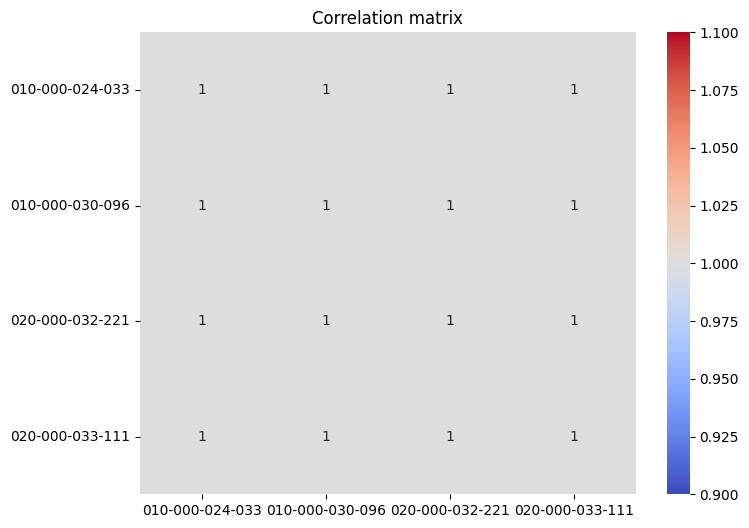

In [68]:
eda.plot_corr_matrix_categorical()

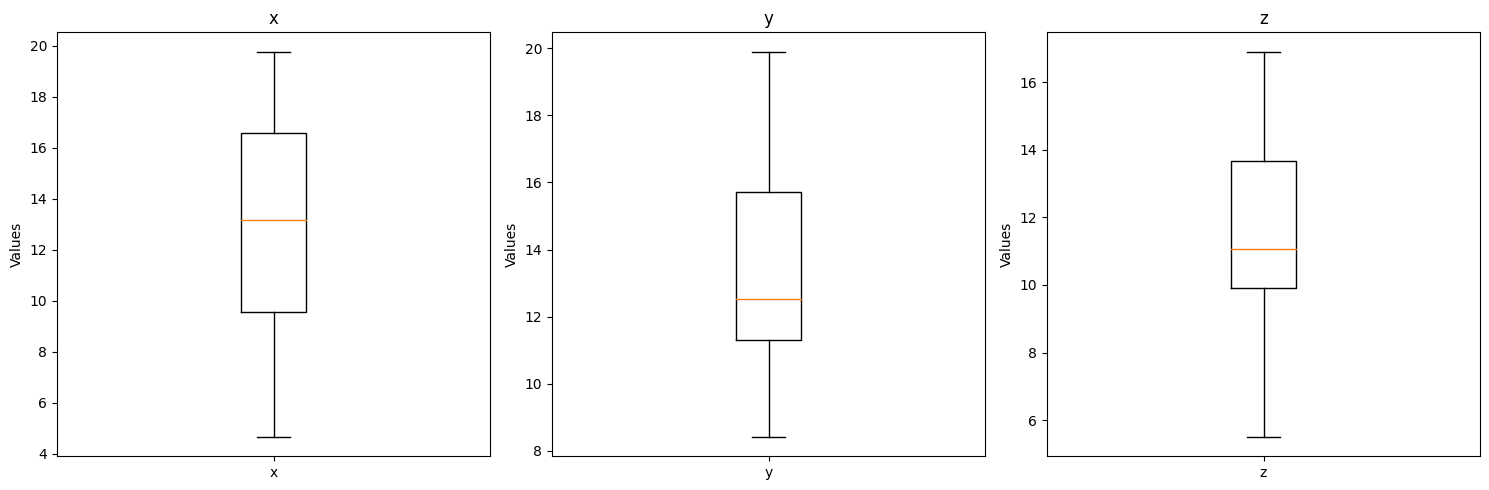

In [69]:
eda = EDA(fp_test, anomaly_test, numerical_columns, categorical_columns)
eda.boxplots()

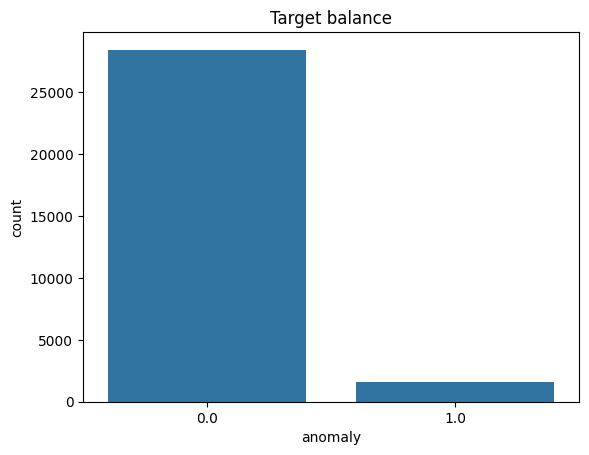

In [70]:
eda.targets_balance()

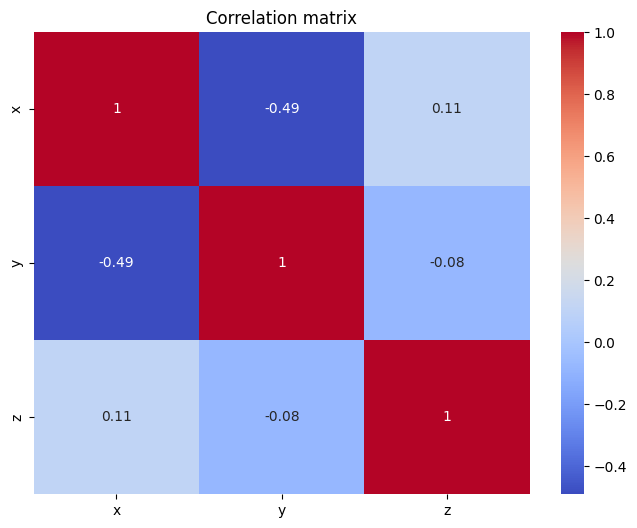

In [71]:
eda.plot_corr_matrix_numerical()

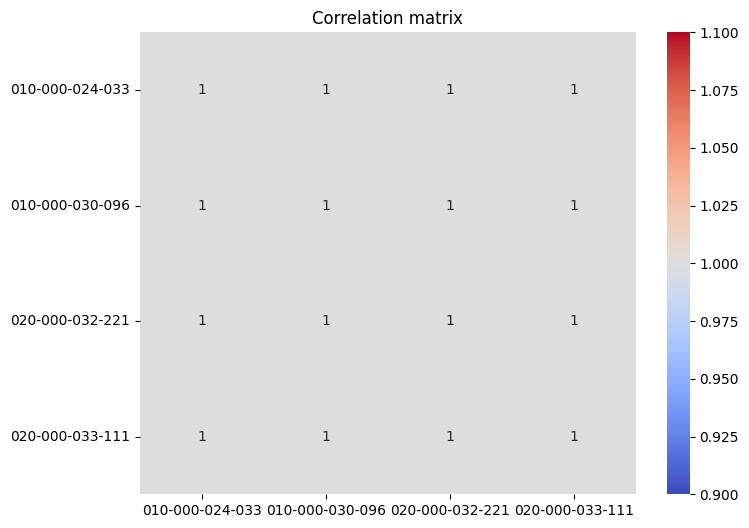

In [72]:
eda.plot_corr_matrix_categorical()

# Data Preprocessing

In [73]:
class Preprocessing:
    def __init__(self, dataset, target, numerical_columns, categorical_columns):
        self.dataset = dataset
        self.target = target
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns

    def impute_numerical(self):
        imputer = IterativeImputer(random_state=42, n_nearest_features=5)
        self.dataset[self.numerical_columns] = imputer.fit_transform(self.dataset[numerical_columns])
        return self.dataset[numerical_columns]

    def impute_categorical(self):
        imputer = SimpleImputer(strategy='most_frequent')
        self.dataset[self.categorical_columns] = imputer.fit_transform(self.dataset[self.categorical_columns])
        return self.dataset[self.categorical_columns]

    def remove_outliers_numerical(self, Q1_p=0.25, Q3_p=0.75, tol=1.5):
        for column in self.numerical_columns:
            Q1 = self.dataset[column].quantile(Q1_p)
            Q3 = self.dataset[column].quantile(Q3_p)
            IQR = Q3 - Q1
            lower_bound = Q1 - tol * IQR
            upper_bound = Q3 + tol * IQR
            outliers = self.dataset[(self.dataset[column] < lower_bound) | (self.dataset[column] > upper_bound)]
            self.dataset = self.dataset.drop(outliers.index)
        return self.dataset[self.numerical_columns]

    def select_features_categorical(self, percentile=50):
        self.impute_categorical()
        print(self.dataset.shape)
        print(self.target.shape)

        label_encoders = {}
        for col in self.categorical_columns:
            label_encoders[col] = LabelEncoder()
            self.dataset[col] = label_encoders[col].fit_transform(self.dataset[col])

        X = self.dataset[self.categorical_columns]

        selector = SelectPercentile(score_func=chi2, percentile=percentile)
        X_selected = selector.fit_transform(X, self.target)

        selected_columns = X.columns[selector.get_support()]

        return selected_columns

    def normalize(self):
        scaler = MinMaxScaler()
        self.dataset[numerical_columns] = scaler.fit_transform(self.dataset[numerical_columns])
        return self.dataset[numerical_columns]

In [74]:
preprocessor = Preprocessing(fp_train, anomaly_train, numerical_columns, categorical_columns)
fp_train[numerical_columns] = preprocessor.remove_outliers_numerical()

In [75]:
fp_train.count()

x                  133991
y                  133991
z                  133991
010-000-024-033    134229
010-000-030-096    134229
020-000-032-221    134229
020-000-033-111    134229
dtype: int64

In [76]:
preprocessor = Preprocessing(fp_train, anomaly_train, numerical_columns, categorical_columns)
fp_train[numerical_columns] = preprocessor.impute_numerical()

In [77]:
fp_train.count()

x                  134229
y                  134229
z                  134229
010-000-024-033    134229
010-000-030-096    134229
020-000-032-221    134229
020-000-033-111    134229
dtype: int64

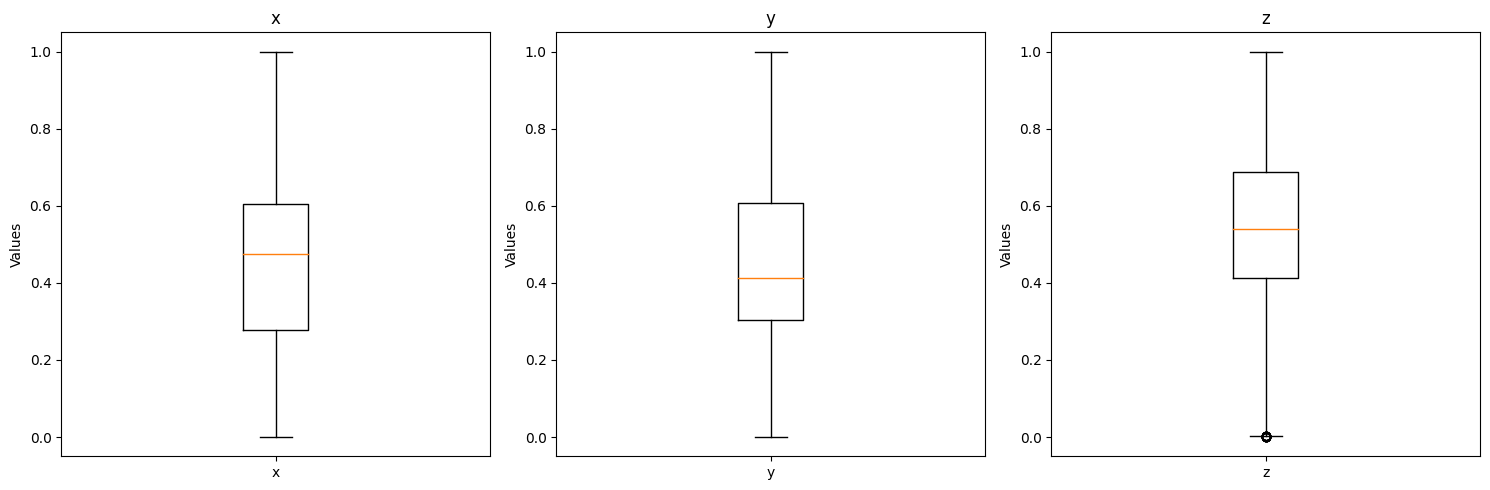

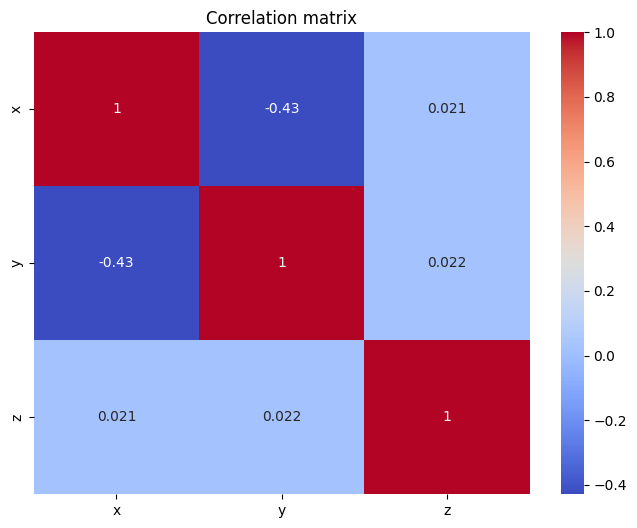

In [78]:
fp_train[numerical_columns] = preprocessor.normalize()
eda = EDA(fp_train, anomaly_train, numerical_columns, categorical_columns)
eda.boxplots()
eda.plot_corr_matrix_numerical()

In [79]:
preprocessor = Preprocessing(fp_test, anomaly_test, numerical_columns, categorical_columns)
fp_test[numerical_columns] = preprocessor.remove_outliers_numerical()

In [80]:
fp_test.count()

x                  30030
y                  30030
z                  30030
010-000-024-033    30030
010-000-030-096    30030
020-000-032-221    30030
020-000-033-111    30030
dtype: int64

In [81]:
preprocessor = Preprocessing(fp_test, anomaly_test, numerical_columns, categorical_columns)
fp_test[numerical_columns] = preprocessor.normalize()

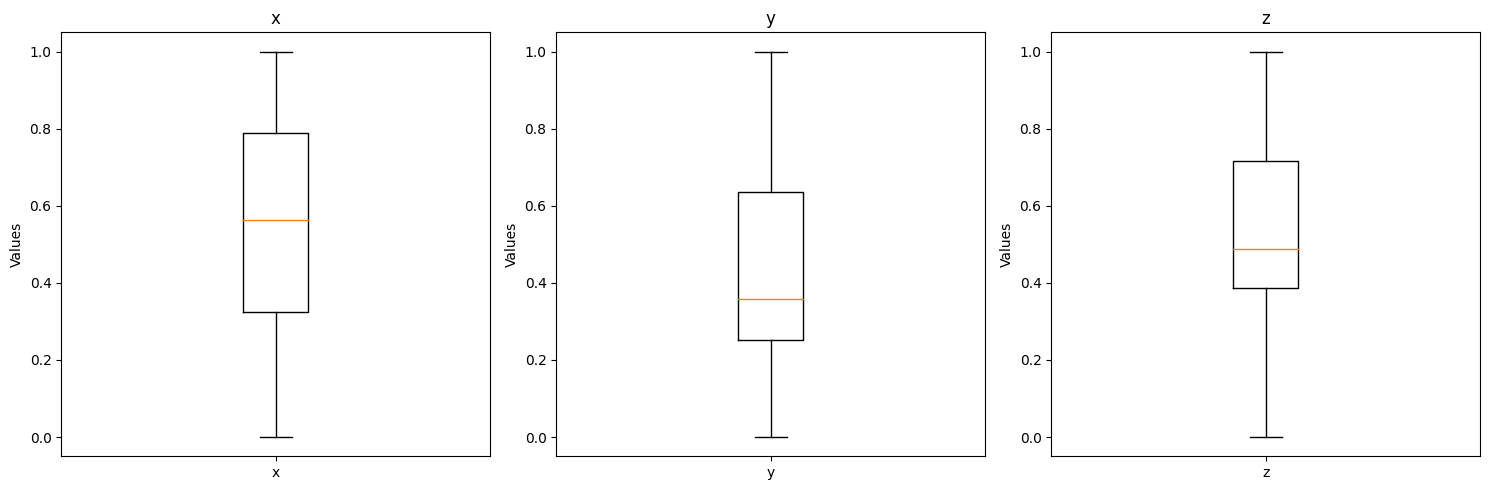

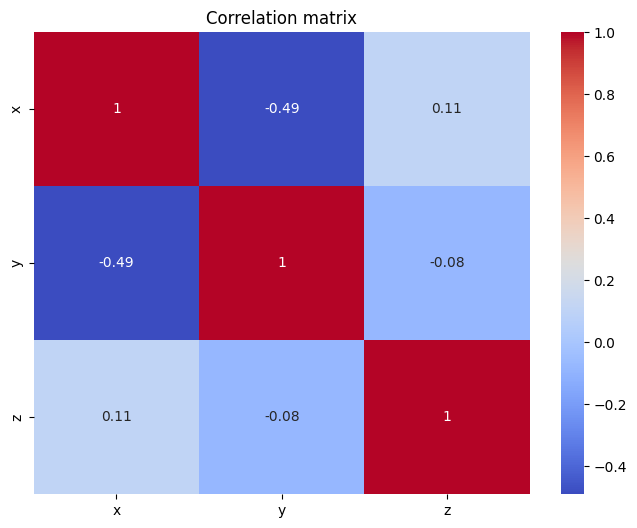

In [82]:
eda = EDA(fp_test, anomaly_test, numerical_columns, categorical_columns)
eda.boxplots()
eda.plot_corr_matrix_numerical()

# Training

In [83]:
# from pyod.utils.utility import evaluate_print


class AnomalyDetector:
    def __init__(self,
                 train,
                 test,
                 target_train,
                 target_test,
                 numerical_columns,
                 categorical_columns,
                 estimator,
                 param_grid):
        self.train = train
        self.test = test
        self.target_train = target_train
        self.target_test = target_test
        self.numerical_columns = numerical_columns
        self.categorical_columns = categorical_columns
        self.estimator = estimator
        self.param_grid = param_grid

    def encode(self):
        encoder = LabelEncoder()
        for column in self.categorical_columns:
            self.train[column] = encoder.fit_transform(self.train[column])

        encoder = LabelEncoder()
        for column in self.categorical_columns:
            self.test[column] = encoder.fit_transform(self.test[column])

        return self.train[self.categorical_columns], self.test[self.categorical_columns]

    def dunn_index(self, X, labels):
        intra_cluster_distances = []
        inter_cluster_distances = []
        clusters = np.unique(labels)

        for cluster in clusters:
            cluster_points = X[labels == cluster]
            intra_dist = pairwise_distances(cluster_points).max() if len(cluster_points) > 1 else 0
            intra_cluster_distances.append(intra_dist)

            for other_cluster in clusters:
                if cluster != other_cluster:
                    other_cluster_points = X[labels == other_cluster]
                    inter_dist = pairwise_distances(cluster_points, other_cluster_points).min()
                    inter_cluster_distances.append(inter_dist)

        return np.min(inter_cluster_distances) / np.max(intra_cluster_distances)

    def silhouette(self, X, labels):
        return silhouette_score(X, labels)

    def find_best_parameters(self):
        X_train = self.train[self.numerical_columns]
        X_test = self.test[self.numerical_columns]

        randomized_search = RandomizedSearchCV(
            estimator=self.estimator,
            param_distributions=self.param_grid,
            n_iter=20,
            scoring='roc_auc',
            cv=3,
            verbose=2,
            random_state=42,
            n_jobs=-1
        )

        randomized_search.fit(X_train, self.target_train)

        best_model = randomized_search.best_estimator_
        best_params = randomized_search.best_params_
        best_auc = randomized_search.best_score_

        y_test_scores = best_model.decision_function(X_test)
        y_test_pred = best_model.predict(X_test)
        auc_score_test = roc_auc_score(self.target_test, y_test_scores)

        silhouette_score_value = self.silhouette(X_test, y_test_pred)
        dunn_index = self.dunn_index(X_test, y_test_pred)

        print(f"Test AUC score: {auc_score_test}")
        print(f"Best Cross-Validated AUC: {best_auc}")
        print(f"Best Parameters: {best_params}")

        return best_model, best_params, auc_score_test, dunn_index, silhouette_score_value

In [84]:
anomaly_train[anomaly_train == 0.0].shape

(127656,)

In [85]:
anomaly_train[anomaly_train == 1.0].shape

(6573,)

In [86]:
anomaly_test[anomaly_test == 0.0].shape

(28420,)

In [87]:
anomaly_test[anomaly_test == 1.0].shape

(1610,)

In [88]:
def filter_ocsvm_params(params):
    # Ensure the kernel parameter is set correctly
    kernel = params.get('kernel', 'rbf')
    
    # Remove `gamma` for 'linear' kernel
    if kernel == 'linear':
        params.pop('gamma', None)
    # Remove `degree` for 'linear' and 'rbf' kernels
    if kernel in ['linear', 'rbf']:
        params.pop('degree', None)
    
    return params

def train_and_evaluate_model(model_class, param_grid, train_data, test_data, anomaly_train, anomaly_test, evaluate_print):
    for params in param_grid:
        print("################################################################################################################################################################")
        print(f"Training model with parameters: {params}")
        
        filtered_params = filter_ocsvm_params(params)

        model = model_class(**filtered_params)

        model.fit(train_data)

        y_train_pred = model.labels_
        y_train_scores = model.decision_scores_

        print(f"Training Evaluation for params: {params}")
        evaluate_print(model_class.__name__, anomaly_train, y_train_scores)

        cm_train = confusion_matrix(anomaly_train, y_train_pred)
        disp_train = ConfusionMatrixDisplay(confusion_matrix=cm_train, display_labels=["Normal", "Anomaly"])
        disp_train.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - Training for {model_class.__name__} (params: {params})")
        plt.show()

        y_test_scores = model.decision_function(test_data)

        print(f"Test Evaluation for params: {params}")
        evaluate_print(model_class.__name__, anomaly_test, y_test_scores)

        y_preds = model.predict(test_data)

        cm_test = confusion_matrix(anomaly_test, y_preds)
        disp_test = ConfusionMatrixDisplay(confusion_matrix=cm_test, display_labels=["Normal", "Anomaly"])
        disp_test.plot(cmap=plt.cm.Blues)
        plt.title(f"Confusion Matrix - Test for {model_class.__name__} (params: {params})")
        plt.show()
        print("################################################################################################################################################################\n")


################################################################################################################################################################
Training model with parameters: {'contamination': 0.052429585586509134, 'n_neighbors': 5, 'n_jobs': -1}
Training Evaluation for params: {'contamination': 0.052429585586509134, 'n_neighbors': 5, 'n_jobs': -1}
KNN ROC:0.6598, precision @ rank n:0.0645


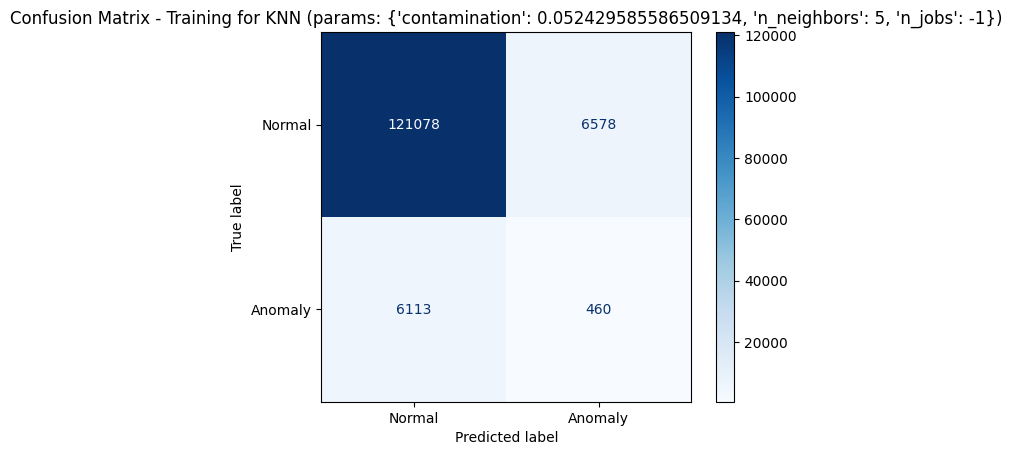

Test Evaluation for params: {'contamination': 0.052429585586509134, 'n_neighbors': 5, 'n_jobs': -1}
KNN ROC:0.3745, precision @ rank n:0.0006


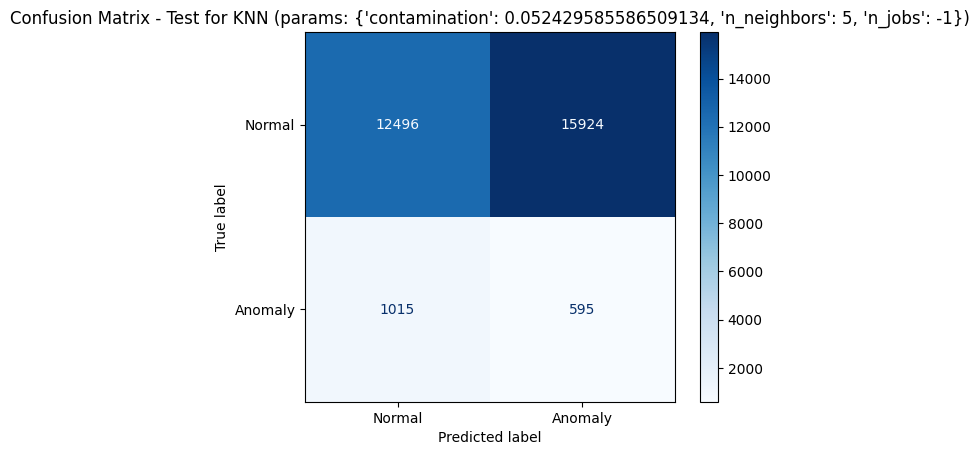

################################################################################################################################################################

################################################################################################################################################################
Training model with parameters: {'contamination': 0.052429585586509134, 'n_neighbors': 10, 'n_jobs': -1}
Training Evaluation for params: {'contamination': 0.052429585586509134, 'n_neighbors': 10, 'n_jobs': -1}
KNN ROC:0.6577, precision @ rank n:0.0599


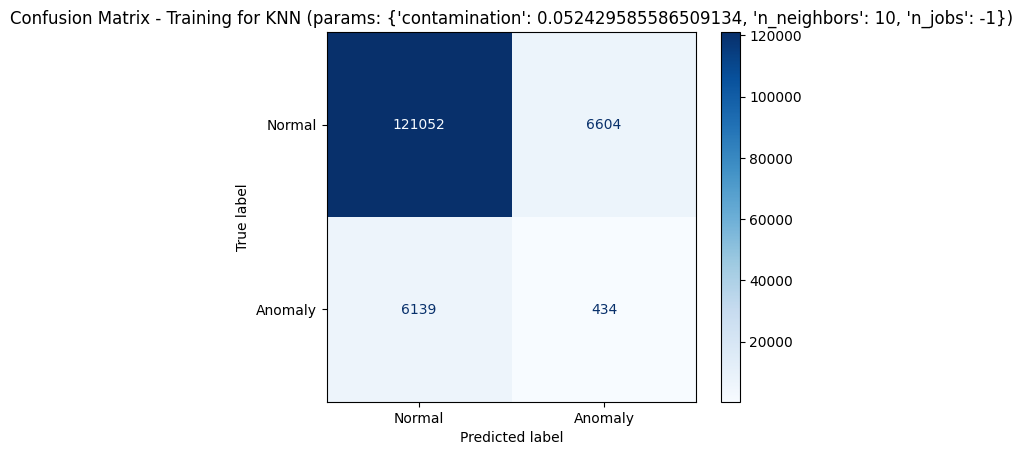

Test Evaluation for params: {'contamination': 0.052429585586509134, 'n_neighbors': 10, 'n_jobs': -1}
KNN ROC:0.3767, precision @ rank n:0.0006


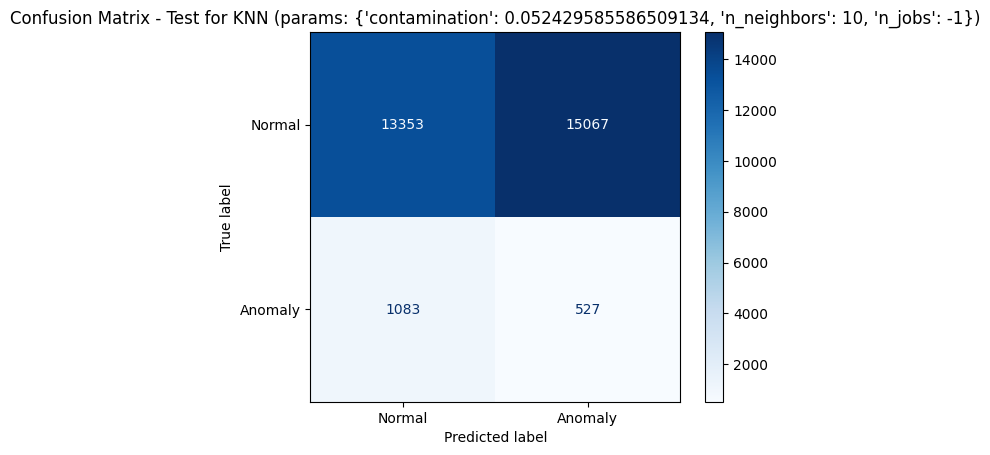

################################################################################################################################################################

################################################################################################################################################################
Training model with parameters: {'contamination': 0.052429585586509134, 'n_neighbors': 15, 'n_jobs': -1}
Training Evaluation for params: {'contamination': 0.052429585586509134, 'n_neighbors': 15, 'n_jobs': -1}
KNN ROC:0.6523, precision @ rank n:0.056


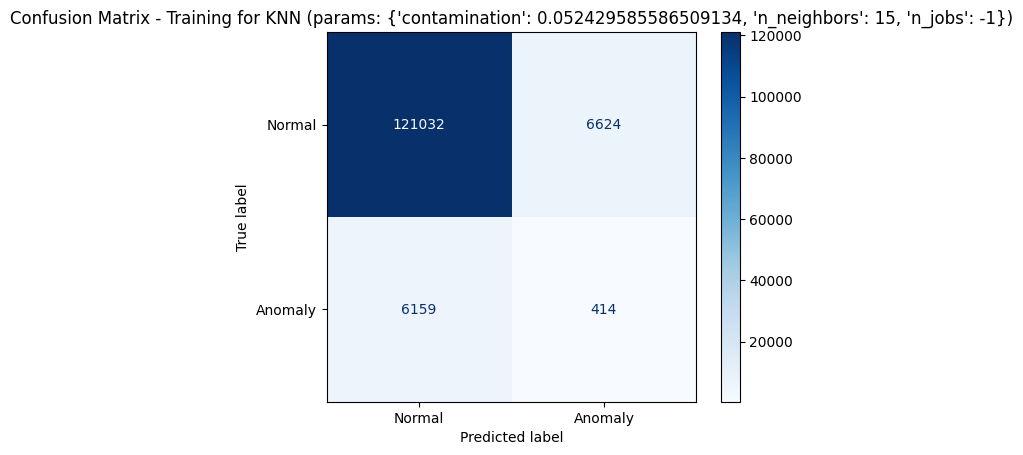

Test Evaluation for params: {'contamination': 0.052429585586509134, 'n_neighbors': 15, 'n_jobs': -1}
KNN ROC:0.38, precision @ rank n:0.0


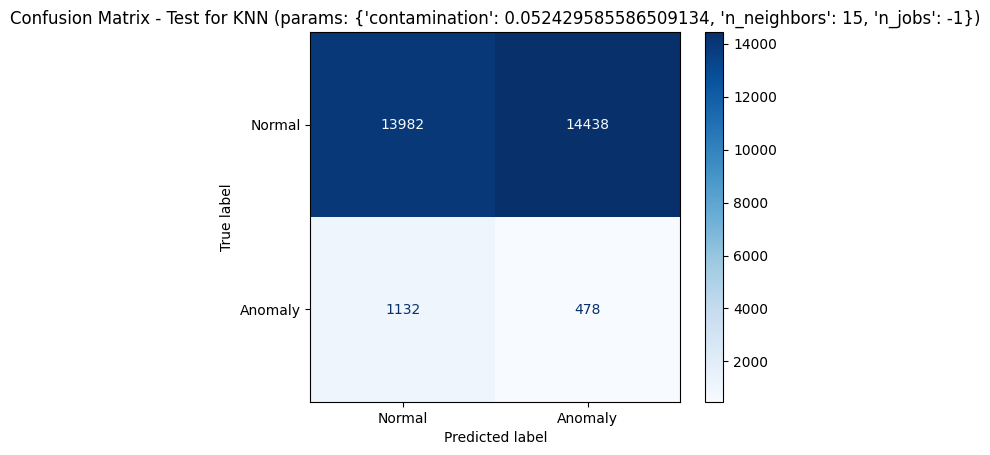

################################################################################################################################################################



In [89]:
from pyod.utils.data import evaluate_print
param_grid = [
    {'contamination': 8183/156076, 'n_neighbors': 5, 'n_jobs': -1},
    {'contamination': 8183/156076, 'n_neighbors': 10, 'n_jobs': -1},
    {'contamination': 8183/156076, 'n_neighbors': 15, 'n_jobs': -1}
]

train_and_evaluate_model(KNN, param_grid, fp_train, fp_test, anomaly_train, anomaly_test, evaluate_print)

################################################################################################################################################################
Training model with parameters: {'kernel': 'poly', 'nu': 0.1, 'gamma': 0.01, 'degree': 3}
Training Evaluation for params: {'kernel': 'poly', 'nu': 0.1, 'gamma': 0.01, 'degree': 3}
OCSVM ROC:0.7136, precision @ rank n:0.2644


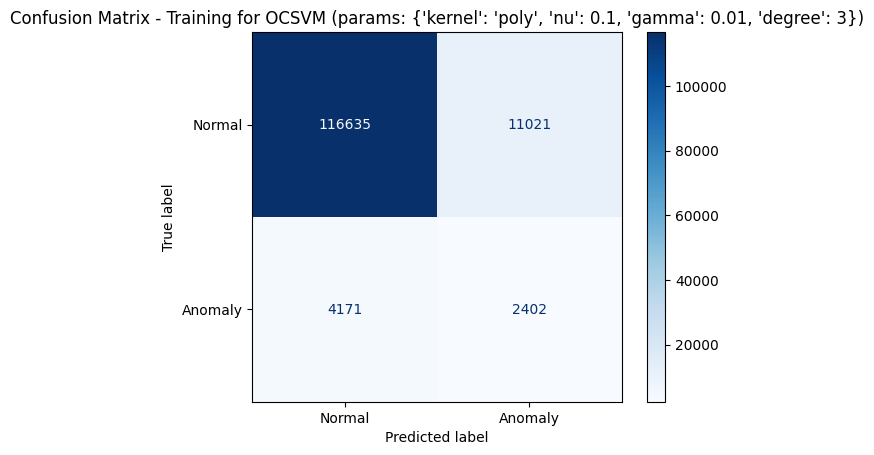

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


Test Evaluation for params: {'kernel': 'poly', 'nu': 0.1, 'gamma': 0.01, 'degree': 3}
OCSVM ROC:0.7829, precision @ rank n:0.3894


C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


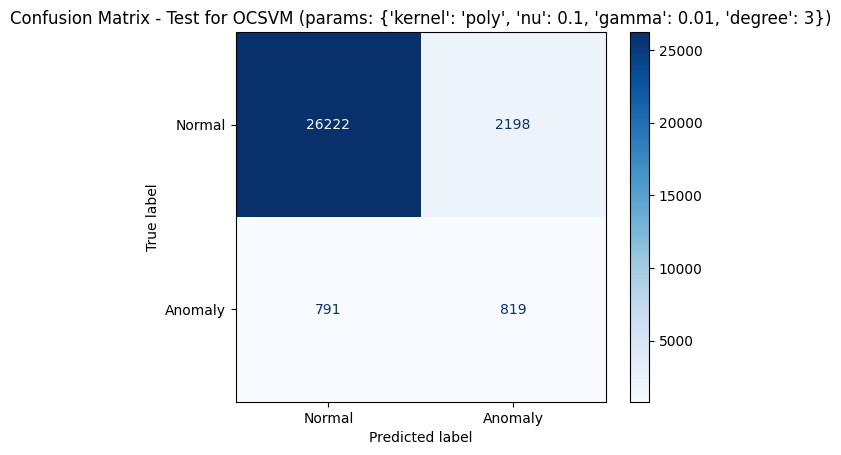

################################################################################################################################################################

################################################################################################################################################################
Training model with parameters: {'kernel': 'poly', 'nu': 0.2, 'gamma': 0.01, 'degree': 3}
Training Evaluation for params: {'kernel': 'poly', 'nu': 0.2, 'gamma': 0.01, 'degree': 3}
OCSVM ROC:0.7095, precision @ rank n:0.2646


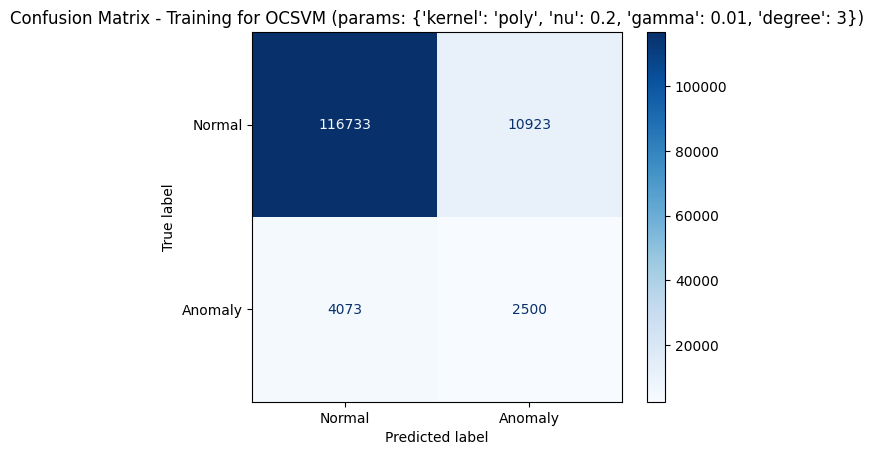

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


Test Evaluation for params: {'kernel': 'poly', 'nu': 0.2, 'gamma': 0.01, 'degree': 3}
OCSVM ROC:0.7824, precision @ rank n:0.3907


C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


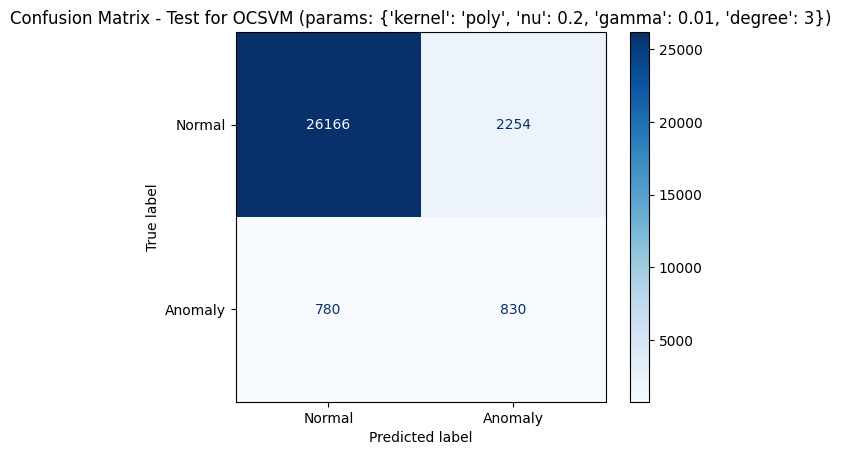

################################################################################################################################################################

################################################################################################################################################################
Training model with parameters: {'kernel': 'poly', 'nu': 0.3, 'gamma': 0.1, 'degree': 3}
Training Evaluation for params: {'kernel': 'poly', 'nu': 0.3, 'gamma': 0.1, 'degree': 3}
OCSVM ROC:0.7099, precision @ rank n:0.2641


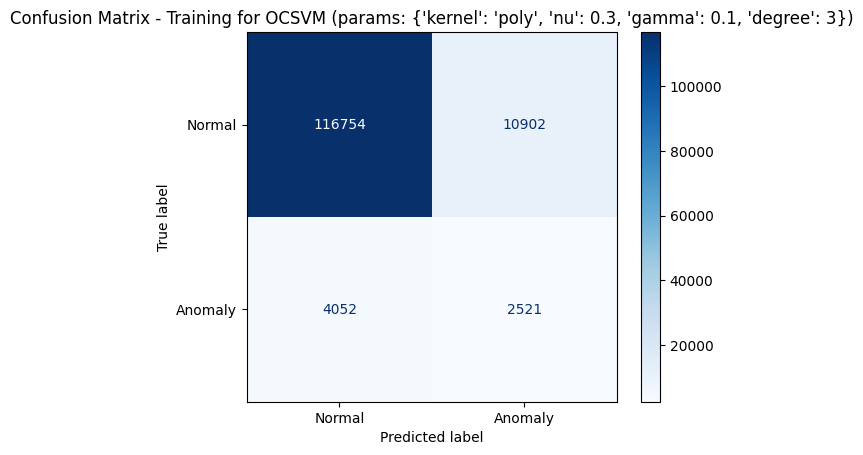

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


Test Evaluation for params: {'kernel': 'poly', 'nu': 0.3, 'gamma': 0.1, 'degree': 3}
OCSVM ROC:0.7835, precision @ rank n:0.3919


C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


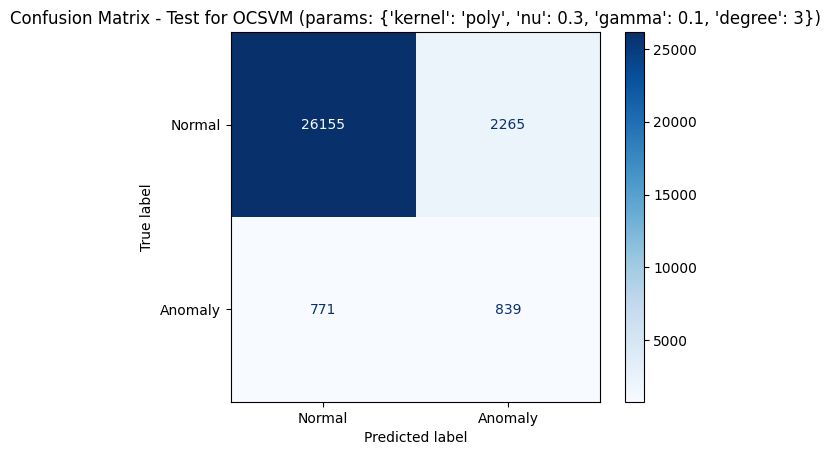

################################################################################################################################################################

################################################################################################################################################################
Training model with parameters: {'kernel': 'poly', 'nu': 0.1, 'gamma': 0.1, 'degree': 4}
Training Evaluation for params: {'kernel': 'poly', 'nu': 0.1, 'gamma': 0.1, 'degree': 4}
OCSVM ROC:0.7141, precision @ rank n:0.2646


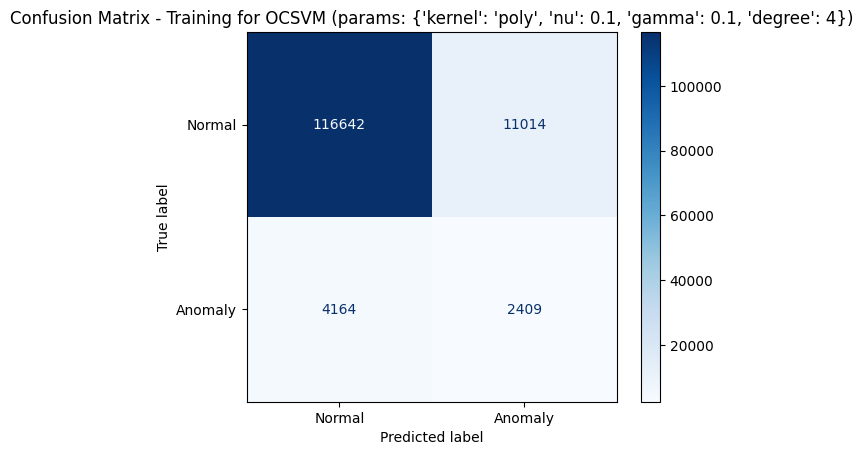

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


Test Evaluation for params: {'kernel': 'poly', 'nu': 0.1, 'gamma': 0.1, 'degree': 4}
OCSVM ROC:0.7836, precision @ rank n:0.3913


C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


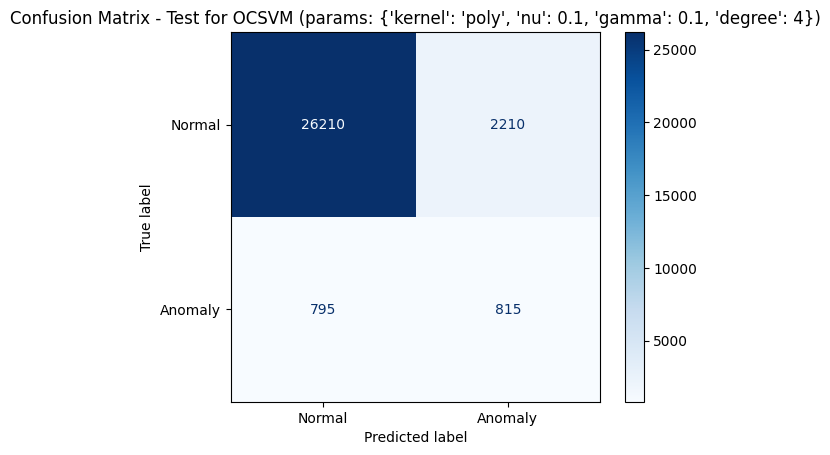

################################################################################################################################################################

################################################################################################################################################################
Training model with parameters: {'kernel': 'linear', 'nu': 0.1}
Training Evaluation for params: {'kernel': 'linear', 'nu': 0.1}
OCSVM ROC:0.7139, precision @ rank n:0.2629


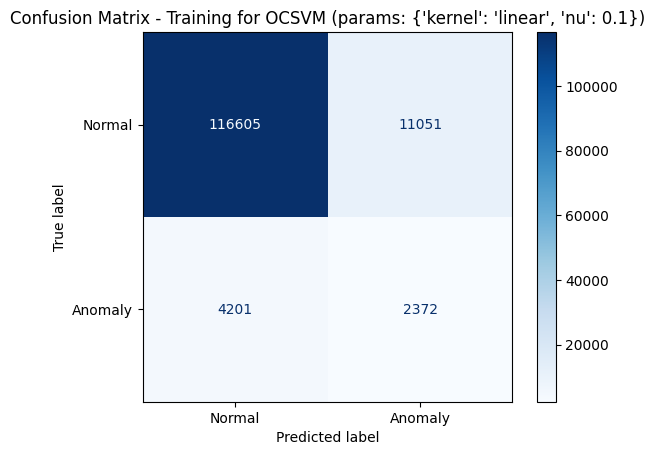

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


Test Evaluation for params: {'kernel': 'linear', 'nu': 0.1}
OCSVM ROC:0.7821, precision @ rank n:0.3913


C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


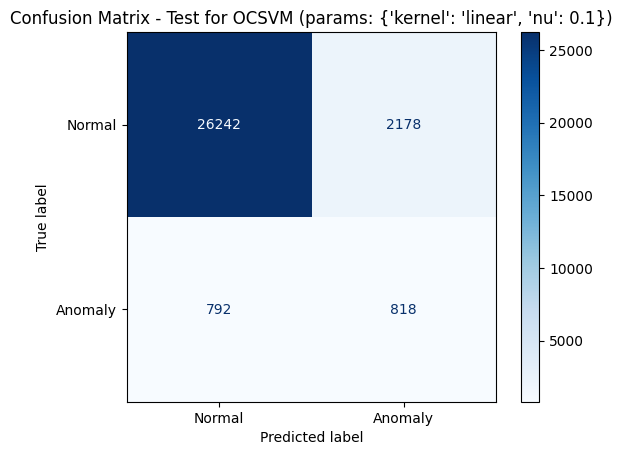

################################################################################################################################################################

################################################################################################################################################################
Training model with parameters: {'kernel': 'linear', 'nu': 0.2}
Training Evaluation for params: {'kernel': 'linear', 'nu': 0.2}
OCSVM ROC:0.7083, precision @ rank n:0.263


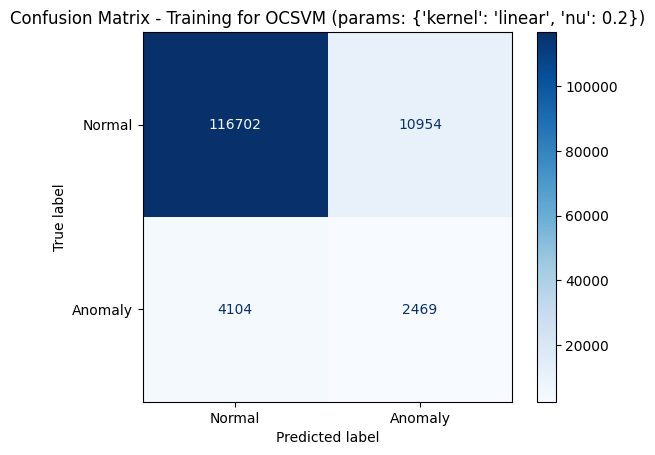

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


Test Evaluation for params: {'kernel': 'linear', 'nu': 0.2}
OCSVM ROC:0.7806, precision @ rank n:0.3925


C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


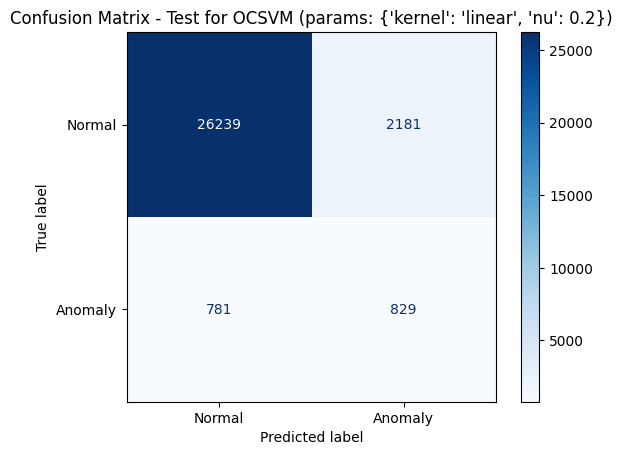

################################################################################################################################################################

################################################################################################################################################################
Training model with parameters: {'kernel': 'linear', 'nu': 0.3}
Training Evaluation for params: {'kernel': 'linear', 'nu': 0.3}
OCSVM ROC:0.7083, precision @ rank n:0.2634


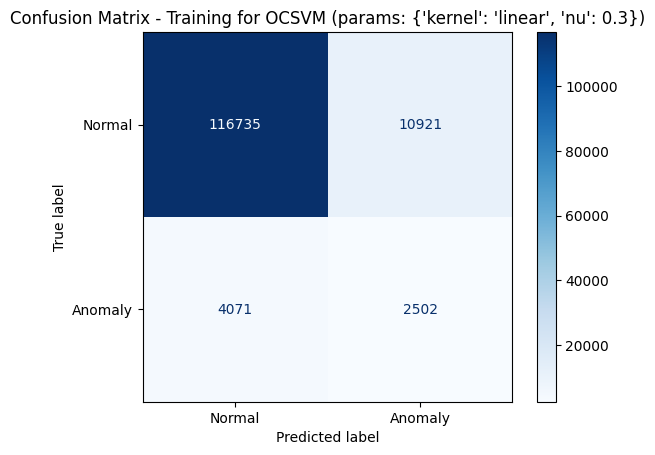

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


Test Evaluation for params: {'kernel': 'linear', 'nu': 0.3}
OCSVM ROC:0.7816, precision @ rank n:0.3913


C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


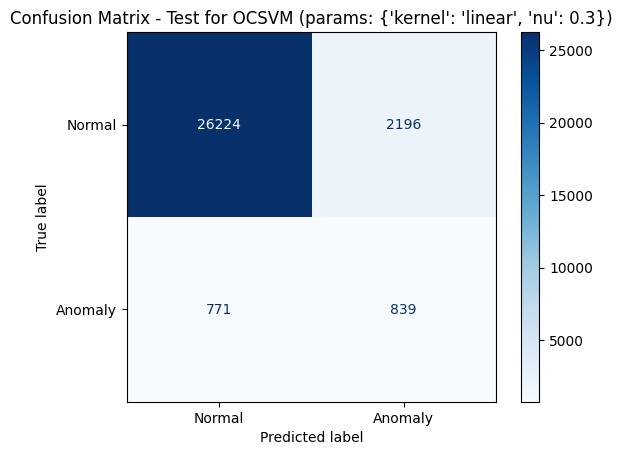

################################################################################################################################################################

################################################################################################################################################################
Training model with parameters: {'kernel': 'linear', 'nu': 0.4}
Training Evaluation for params: {'kernel': 'linear', 'nu': 0.4}
OCSVM ROC:0.7084, precision @ rank n:0.2632


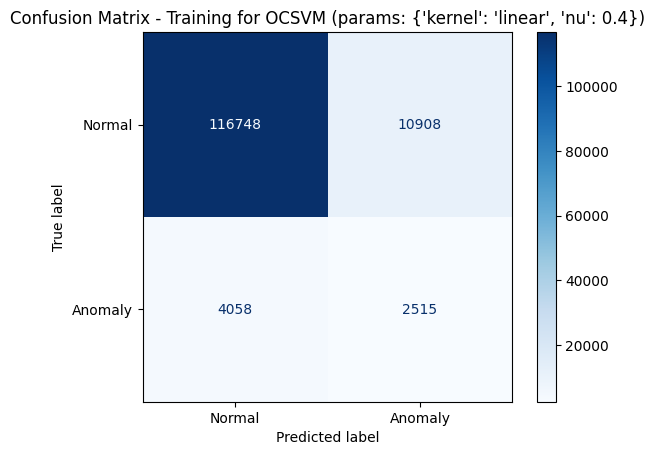

C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


Test Evaluation for params: {'kernel': 'linear', 'nu': 0.4}
OCSVM ROC:0.7823, precision @ rank n:0.3907


C:\Users\Bogdan\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.10_qbz5n2kfra8p0\LocalCache\local-packages\Python310\site-packages\sklearn\base.py:486: UserWarning: X has feature names, but OneClassSVM was fitted without feature names
  warnings.warn(


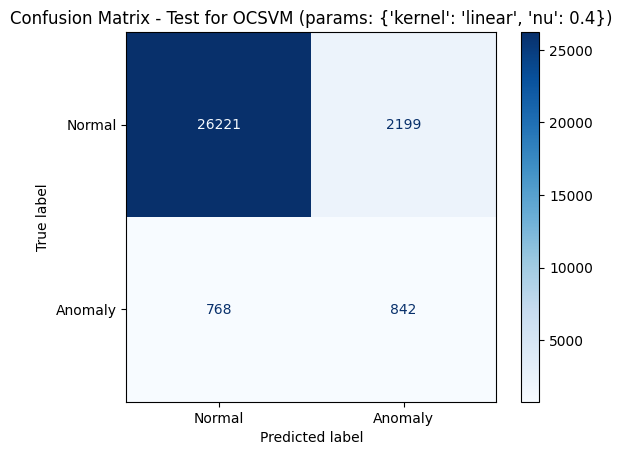

################################################################################################################################################################



In [101]:
param_grid = [
    {'kernel': 'poly', 'nu': 0.1, 'gamma': 0.01, 'degree': 3},
    {'kernel': 'poly', 'nu': 0.2, 'gamma': 0.01, 'degree': 3},
    {'kernel': 'poly', 'nu': 0.3, 'gamma': 0.1, 'degree': 3},
    {'kernel': 'poly', 'nu': 0.1, 'gamma': 0.1, 'degree': 4},
    {'kernel': 'linear', 'nu': 0.1},
    {'kernel': 'linear', 'nu': 0.2},
    {'kernel': 'linear', 'nu': 0.3},
    {'kernel': 'linear', 'nu': 0.4}
]

train_and_evaluate_model(OCSVM, param_grid, fp_train, fp_test, anomaly_train, anomaly_test, evaluate_print)

################################################################################################################################################################
Training model with parameters: {'contamination': 0.052429585586509134, 'n_bins': 10, 'n_random_cuts': 5}
Training Evaluation for params: {'contamination': 0.052429585586509134, 'n_bins': 10, 'n_random_cuts': 5}
LODA ROC:0.5008, precision @ rank n:0.0646


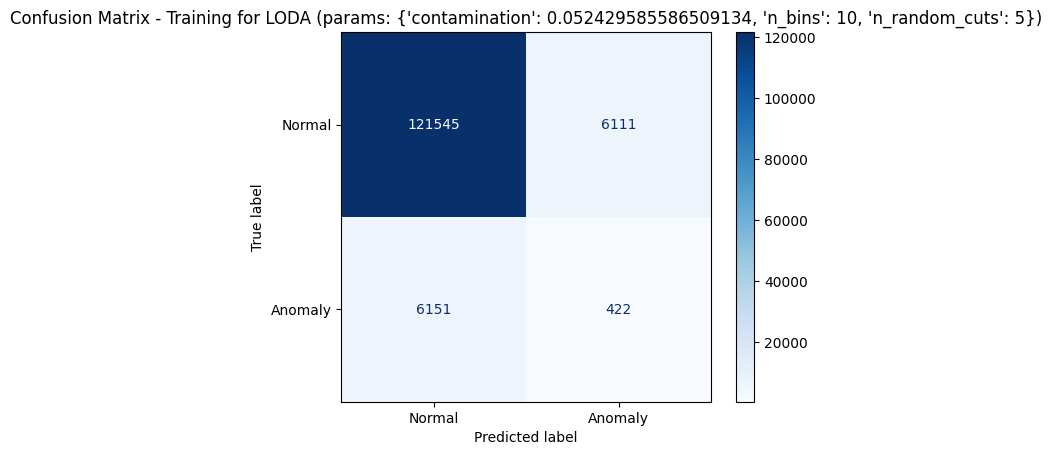

Test Evaluation for params: {'contamination': 0.052429585586509134, 'n_bins': 10, 'n_random_cuts': 5}
LODA ROC:0.4859, precision @ rank n:0.1025


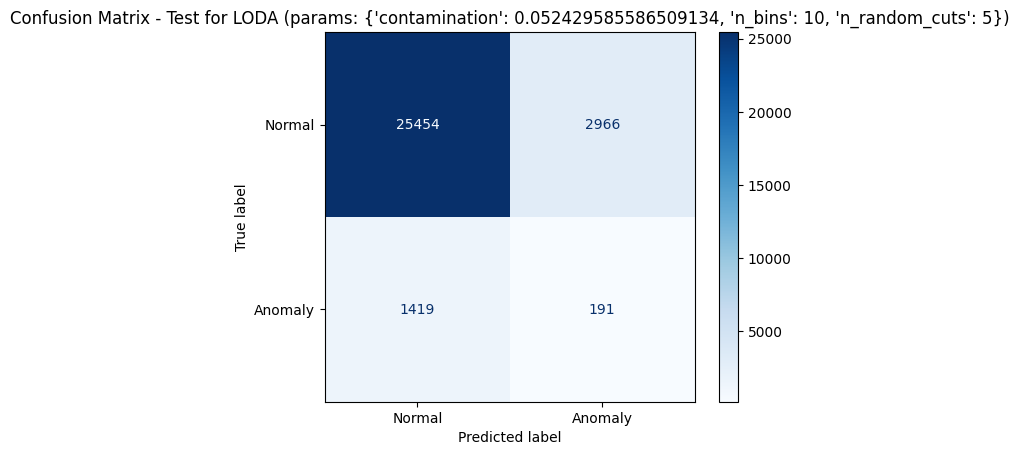

################################################################################################################################################################

################################################################################################################################################################
Training model with parameters: {'contamination': 0.052429585586509134, 'n_bins': 20, 'n_random_cuts': 10}
Training Evaluation for params: {'contamination': 0.052429585586509134, 'n_bins': 20, 'n_random_cuts': 10}
LODA ROC:0.4903, precision @ rank n:0.0728


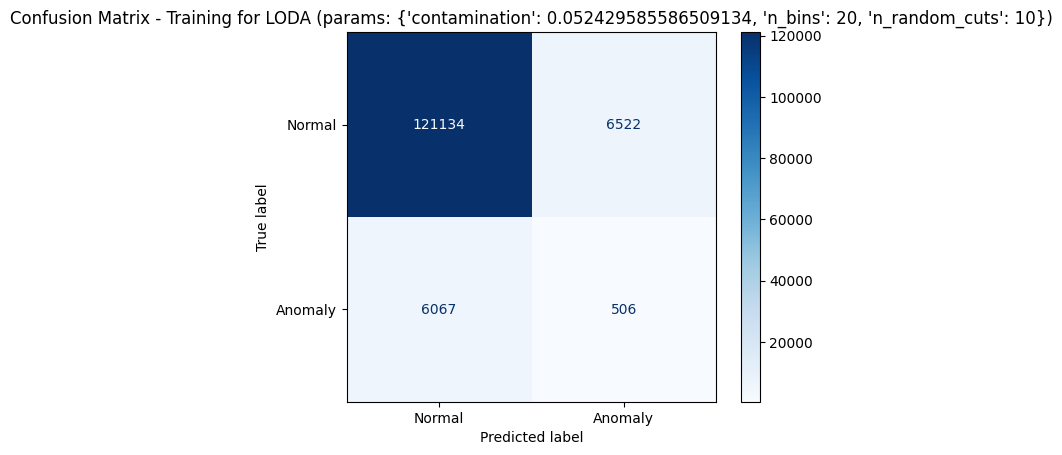

Test Evaluation for params: {'contamination': 0.052429585586509134, 'n_bins': 20, 'n_random_cuts': 10}
LODA ROC:0.5026, precision @ rank n:0.1118


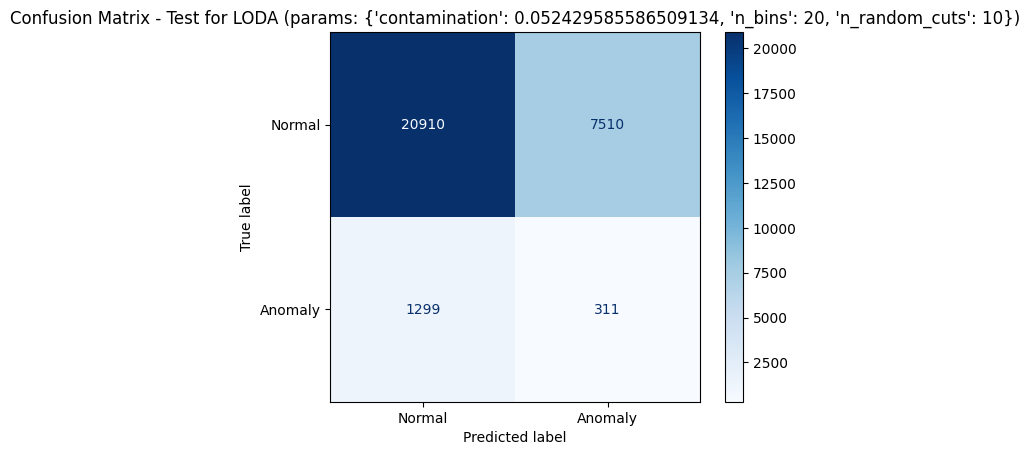

################################################################################################################################################################

################################################################################################################################################################
Training model with parameters: {'contamination': 0.052429585586509134, 'n_bins': 30, 'n_random_cuts': 15}
Training Evaluation for params: {'contamination': 0.052429585586509134, 'n_bins': 30, 'n_random_cuts': 15}
LODA ROC:0.4674, precision @ rank n:0.0222


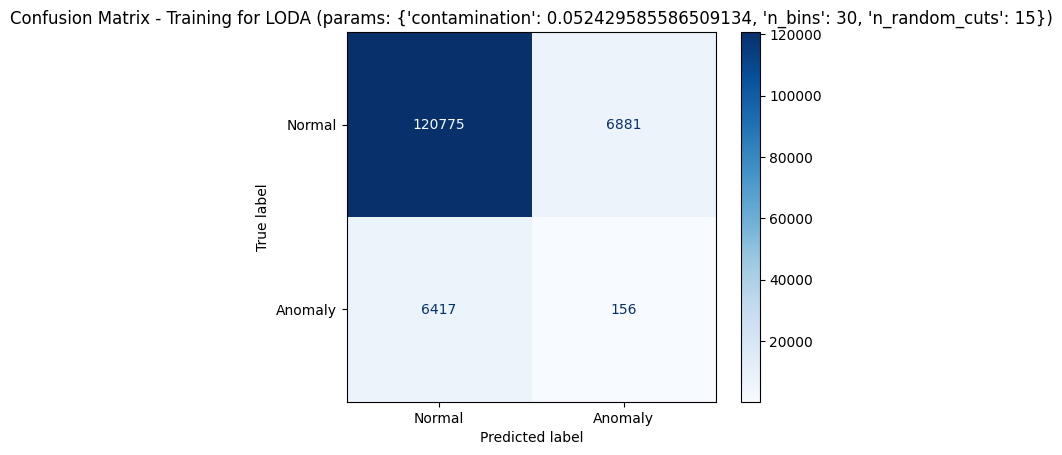

Test Evaluation for params: {'contamination': 0.052429585586509134, 'n_bins': 30, 'n_random_cuts': 15}
LODA ROC:0.4699, precision @ rank n:0.005


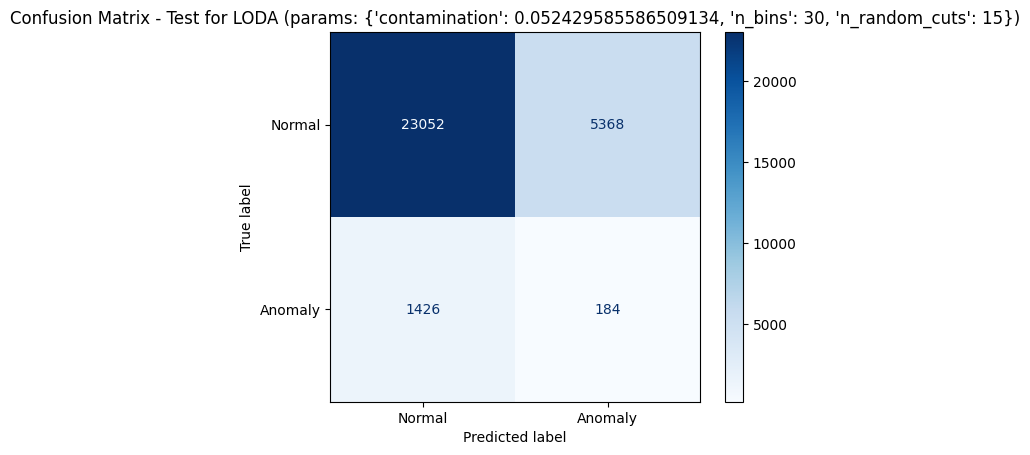

################################################################################################################################################################

################################################################################################################################################################
Training model with parameters: {'contamination': 0.052429585586509134, 'n_bins': 40, 'n_random_cuts': 20}
Training Evaluation for params: {'contamination': 0.052429585586509134, 'n_bins': 40, 'n_random_cuts': 20}
LODA ROC:0.4778, precision @ rank n:0.0577


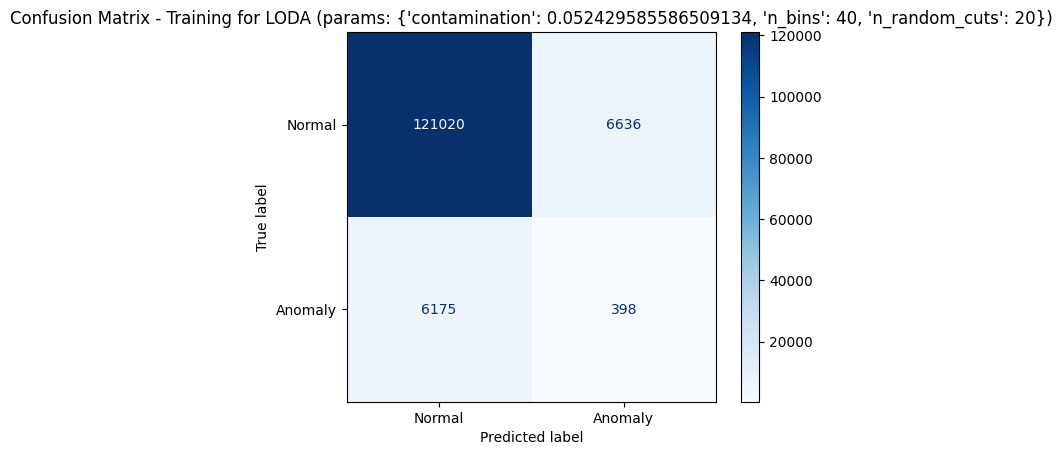

Test Evaluation for params: {'contamination': 0.052429585586509134, 'n_bins': 40, 'n_random_cuts': 20}
LODA ROC:0.504, precision @ rank n:0.0037


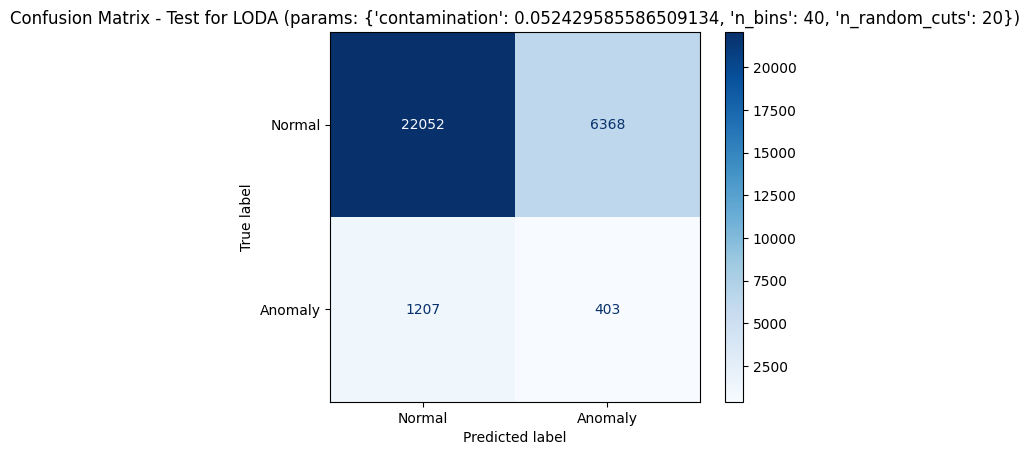

################################################################################################################################################################



In [100]:
param_grid = [
    {'contamination': 8183/156076, 'n_bins': 10, 'n_random_cuts': 5},
    {'contamination': 8183/156076, 'n_bins': 20, 'n_random_cuts': 10},
    {'contamination': 8183/156076, 'n_bins': 30, 'n_random_cuts': 15},
    {'contamination': 8183/156076, 'n_bins': 40, 'n_random_cuts': 20}
]

train_and_evaluate_model(LODA, param_grid, fp_train, fp_test, anomaly_train, anomaly_test, evaluate_print)